In [ ]:
# !unzip train.zip
# !unzip test.zip

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

In [2]:
import os
print(os.listdir("/home/jupyter/fashion_mnist/"))

['train.csv', 'train', 'test.csv', 'test', '.ipynb_checkpoints', 'Identify the apparels.ipynb']


In [3]:
main_path = Path('/home/jupyter/fashion_mnist/')
main_path.ls()

[PosixPath('/home/jupyter/fashion_mnist/train.csv'),
 PosixPath('/home/jupyter/fashion_mnist/train'),
 PosixPath('/home/jupyter/fashion_mnist/test.csv'),
 PosixPath('/home/jupyter/fashion_mnist/test'),
 PosixPath('/home/jupyter/fashion_mnist/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/fashion_mnist/Identify the apparels.ipynb')]

In [4]:
train = pd.read_csv(main_path/'train.csv')
sub_file = pd.read_csv(main_path/'test.csv')

In [5]:
train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [7]:
train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

![](https://i.ibb.co/WK5JN5w/Capture.png)

In [8]:
sub_file.head()

,id
0,60001
1,60002
2,60003
3,60004
4,60005


In [10]:
test_img = ImageList.from_df(sub_file, path=main_path, folder='test', suffix='.png')

databunch = ImageList.from_df(train, path=main_path, folder='train', suffix='.png')\
            .split_by_rand_pct(0.1)\
            .label_from_df()\
            .add_test(test_img)\
            .transform(get_transforms(do_flip=True), size=28)\
            .databunch(path='.', bs=128, device= torch.device('cuda:0'))\
            .normalize(mnist_stats)

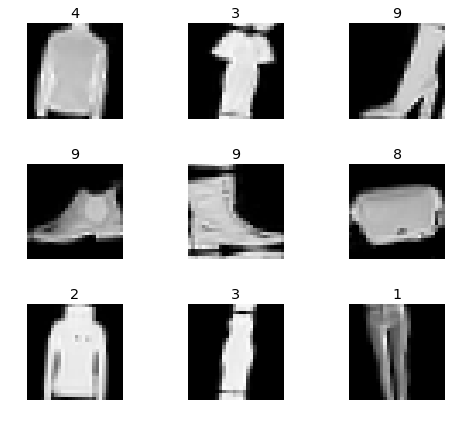

In [11]:
databunch.show_batch(rows=3, figsize=(7,6))

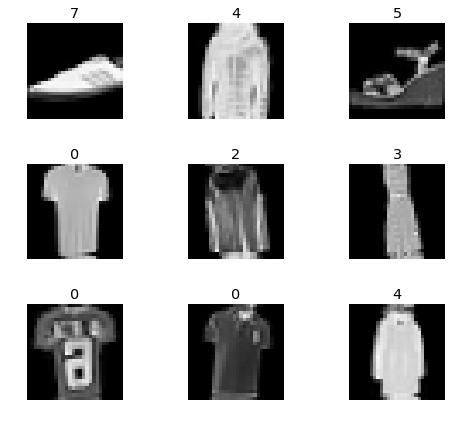

In [12]:
# Validation set
databunch.show_batch(rows=3, figsize=(7,6), is_train=False)

In [10]:
databunch.classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [18]:
databunch.label_list

LabelLists;

Train: LabelList (54000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
9,0,0,3,0
Path: /home/jupyter;

Valid: LabelList (6000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,7,2,9,3
Path: /home/jupyter;

Test: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: /home/jupyter

In [15]:
databunch.train_ds[0][0]

In [16]:
databunch.valid_ds[0][0]

In [18]:
databunch.test_ds[0][0]

In [38]:
train_classes = Counter(databunch.train_ds.y)
train_classes.most_common()

[(Category 0, 5442),
 (Category 3, 5431),
 (Category 9, 5409),
 (Category 7, 5402),
 (Category 4, 5400),
 (Category 2, 5399),
 (Category 8, 5399),
 (Category 1, 5384),
 (Category 6, 5375),
 (Category 5, 5359)]

In [82]:
train_classes = {k: (v/54000)*100 for k, v in train_classes.items()}
train_classes

{Category 9: 0.16694444444444442,
 Category 0: 0.16796296296296295,
 Category 3: 0.16762345679012344,
 Category 2: 0.1666358024691358,
 Category 5: 0.1654012345679012,
 Category 7: 0.1667283950617284,
 Category 6: 0.16589506172839508,
 Category 4: 0.16666666666666669,
 Category 1: 0.16617283950617284,
 Category 8: 0.1666358024691358}

In [83]:
valid_classes = Counter(databunch.valid_ds.y)
valid_classes.most_common()

[(Category 5, 641),
 (Category 6, 625),
 (Category 1, 616),
 (Category 2, 601),
 (Category 8, 601),
 (Category 4, 600),
 (Category 7, 598),
 (Category 9, 591),
 (Category 3, 569),
 (Category 0, 558)]

In [84]:
valid_classes = {k: (v/6000)*100 for k, v in valid_classes.items()}
valid_classes

{Category 3: 9.483333333333334,
 Category 7: 9.966666666666667,
 Category 2: 10.016666666666667,
 Category 9: 9.85,
 Category 8: 10.016666666666667,
 Category 4: 10.0,
 Category 1: 10.266666666666667,
 Category 6: 10.416666666666668,
 Category 5: 10.683333333333334,
 Category 0: 9.3}

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


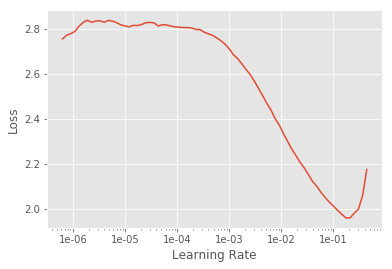

In [13]:
learner = cnn_learner(databunch, models.resnet34, 
                      metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()
learner.lr_find();
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(5, max_lr=slice(3e-02, 5e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.569271,0.563735,0.206833,0.793167,00:28
1,0.487702,0.525217,0.196667,0.803333,00:28
2,0.416583,0.403819,0.153500,0.846500,00:29
3,0.370473,0.320558,0.118167,0.881833,00:29
4,0.344508,0.289453,0.107667,0.892333,00:28


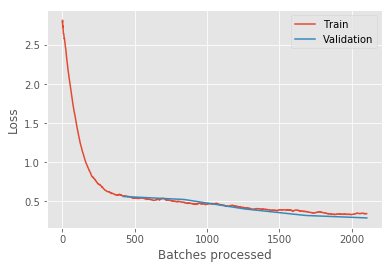

In [15]:
learner.recorder.plot_losses()

In [16]:
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(3e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.560680,0.527295,0.166833,0.833167,00:38
1,0.514742,0.372615,0.130667,0.869333,00:37
2,0.406393,0.290933,0.106667,0.893333,00:37
3,0.338881,0.245159,0.089833,0.910167,00:37
4,0.281849,0.232122,0.084167,0.915833,00:37


In [17]:
learner.save('stage-1-rn34')

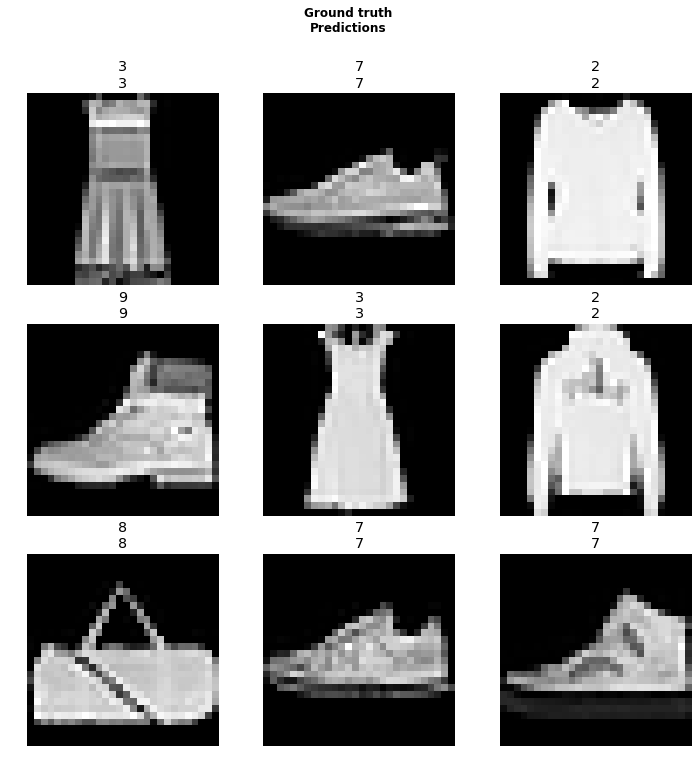

In [19]:
learner.show_results(rows=3)

In [20]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(databunch.valid_ds)==len(losses)==len(idxs)

True

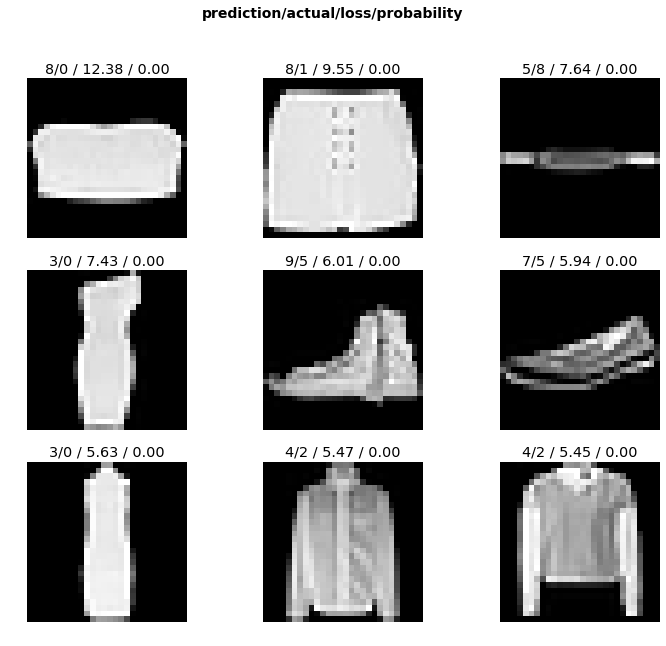

In [21]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

Model's confusion is real I think.

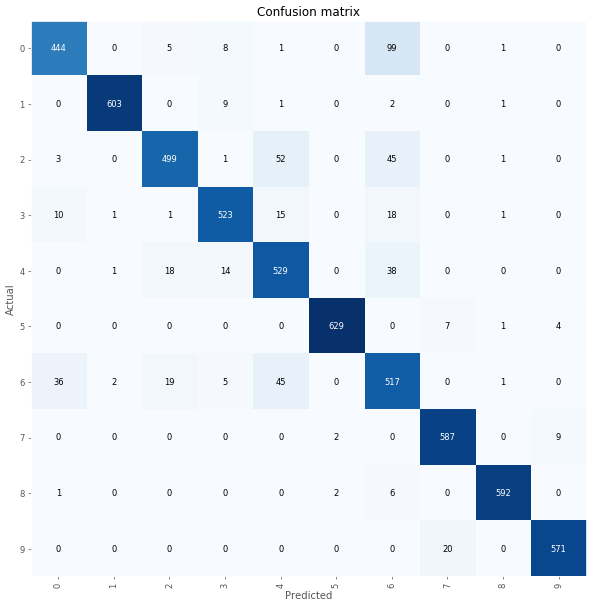

In [22]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [23]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, main_path/'fashion_mnist')

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [24]:
cleaned = pd.read_csv('/home/jupyter/fashion_mnist/cleaned.csv')
cleaned.head()

,name,label
0,train/1.png,9
1,train/2.png,0
2,train/3.png,0
3,train/4.png,3
4,train/5.png,0


In [25]:
import re

def clean_string(m):

    re1='.*?'	# Non-greedy match on filler
    re2='(\\d+)'	# Integer Number 1
    re3='(\\.)' 	# Any Single Character 1
    re4='(png)' 	# Word 1

    rg = re.compile(re1+re2+re3+re4,re.IGNORECASE|re.DOTALL)
    clean = rg.search(m)
    if m:
        int1=clean.group(1)
        c1=clean.group(2)
        word1=clean.group(3)
        return str(int1) + str(c1) + str(word1)

In [27]:
cleaned['name'] = cleaned.name.apply(clean_string)
cleaned.head()

,name,label
0,1.png,9
1,2.png,0
2,3.png,0
3,4.png,3
4,5.png,0


In [50]:
databunch = ImageList.from_df(cleaned, path=main_path, folder='train')\
            .split_by_rand_pct(0.1)\
            .label_from_df()\
            .add_test(test_img)\
            .transform(get_transforms(do_flip=True), size=28)\
            .databunch(path='.', bs=128, device= torch.device('cuda:0'))\
            .normalize(mnist_stats)

In [29]:
learner = cnn_learner(databunch, models.resnet34, 
                      metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()

learner.load('stage-1-rn34')

learner.fit_one_cycle(1, max_lr = slice(3e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.292104,0.214714,0.084768,0.915232,00:26


In [32]:
learner.save('stage-2-rn34')

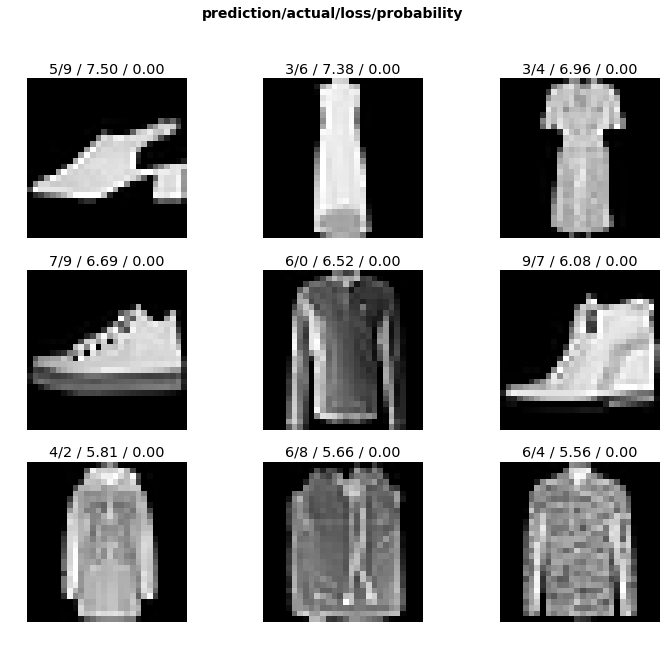

In [152]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

The effects of noise is quite vivid now. In this case, this is mostly **label noise**.

In [51]:
labels = []

for i in range(len(databunch.test_ds)):
    pred_class, _, _ = learner.predict(databunch.test_ds[i][0])
    labels.append(pred_class)
    
labels = list(map(lambda x: str(x).replace('Category', ''), labels))

sub_file['label'] = labels
sub_file.to_csv('submission.csv', index=False)

In [46]:
!head -5 submission.csv 

id,label
60001,0
60002,0
60003,0
60004,0
